# Template for coursework - Part 2: Clustering

In [37]:
# import of libraries
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from scipy import stats
import numpy as np



## Team identification

* seminar day and time
ST 9:15
* team number
Team D
* names of team members
Michal Červinka, Filip Dvořák, Tomáš Jareš, Dominik Šimon

# Introduction

1.	Describe the business value of addressing this problem with machine learning.

    Použití strojového učení na dataset diabetu může výrazně přispět k zlepšení zdravotní péče. Umožňuje časnou detekci a diagnostiku diabetu, vytváření personalizovaných léčebných plánů, předpovídání pravděpodobnosti komplikací, stratifikaci pacientů na základě rizika a efektivní řízení a sledování nemoci. Tímto způsobem může strojové učení zlepšit klinické 
    rozhodování, výsledky pacientů a přispět k efektivnějšímu poskytování zdravotní péče.

2.	Provide the link to the source of the data.
    https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

## Customization

What is the target attribute

        Diabetes

What is the instance of interest   The instance can be identified, for example, by an id.

         Pro testování na jedné instaci jsme zvolili instaci, kde je přítomen diabetes. (index 414)

Choose an attribute of interest

        Diabetes


# Data preprocessing

## Preprocessing for unsupervised machine learning 

* As clustering is  performed only on the chosen subset of data, remove data not in the subgroup
* Perform min-max feature rescaling
* remove target attribute from clustering
* do *not* create train-test splits

In [38]:

data = pd.read_csv("diabetes_prediction_dataset.csv")
data

#Vybrání dat bez cílové proměnné
X = data.drop('diabetes', axis=1)

#Vytvoření subsetu
X=X.drop('gender', axis=1)
X=X.drop('smoking_history',axis=1)
print(X.head())


np.random.seed(10)
X = X.sample(frac=0.01, random_state=11)


# Odstranění vzdálených pozorování
z_scores = stats.zscore(X)
threshold = 3
X = X[(np.abs(z_scores) < threshold).all(axis=1)]


#Standard scaling
scaler = StandardScaler()
X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])
print(X.describe()) #tabulka pro kontrolu min a max value 

print("Number of rows in X:", X.shape[0])

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level
0  80.0             0              1  25.19          6.6                  140
1  54.0             0              0  27.32          6.6                   80
2  28.0             0              0  27.32          5.7                  158
3  36.0             0              0  23.45          5.0                  155
4  76.0             1              1  20.14          4.8                  155
                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  8.660000e+02         866.0          866.0  8.660000e+02  8.660000e+02   
mean   3.261440e-16           0.0            0.0  1.948659e-16  6.892100e-16   
std    1.000578e+00           0.0            0.0  1.000578e+00  1.000578e+00   
min   -1.786615e+00           0.0            0.0 -2.232469e+00 -1.928265e+00   
25%   -8.492887e-01           0.0            0.0 -6.537951e-01 -6.301482e-01   
50%   -2.442267e-02           0.0            0.0  1.

## Modeling and visualization

* do not include target attribute among variables for clustering

### Clustering 1 (k-means)

* Use the elbow curve graph to find the best value of inertia (wcss)
* It is recommended to use two measures (such as the Silhouette score and the Inertia) and compare the resulting number of clusters based on their best values.
* Create a scatter plot for each cluster and use color

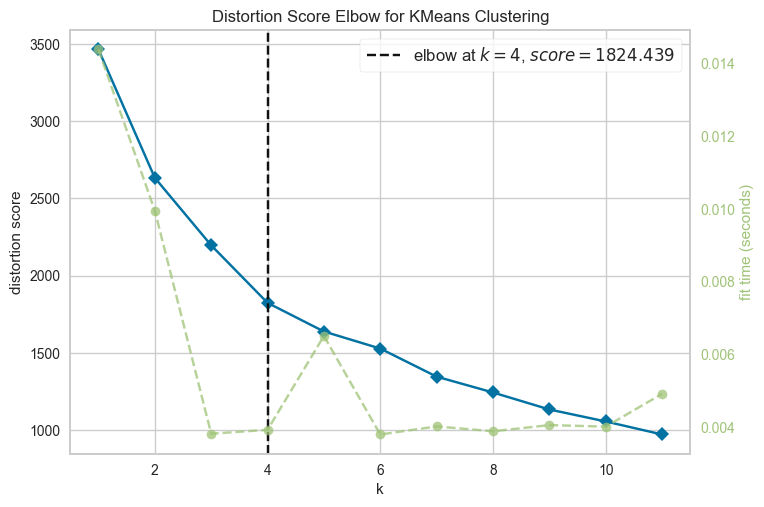

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
#Vizualizace Elbow grafu
kmeans_tune = KMeans(random_state=42,n_init = 2,max_iter=10)
visualizer = KElbowVisualizer(kmeans_tune, k=(1,12))
visualizer.fit(X)
visualizer.show()

In [40]:
kmeansElbow = KMeans(n_clusters=4, random_state=42)
kmeansElbow.fit(X)
# spočítání Silhouette Score:
silhouette_avg = silhouette_score(X, kmeansElbow.labels_)
print("silhouette_score pro K=4:", silhouette_avg)

#výpis inertii
print("inertia pro K=4: ", kmeansElbow.inertia_)

kmeansTwo = KMeans(n_clusters=2, random_state=42)
kmeansTwo.fit(X)
# spočítání Silhouette Score:
silhouette_avg = silhouette_score(X, kmeansTwo.labels_)
print("silhouette_score pro k=2:", silhouette_avg)
#výpis inertii
print("inertia pro k=2: ", kmeansTwo.inertia_)


silhouette_score pro K=4: 0.2362571872791669
inertia pro K=4:  1824.3933076549974
silhouette_score pro k=2: 0.22020063370861973
inertia pro k=2:  2633.459405930618


/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


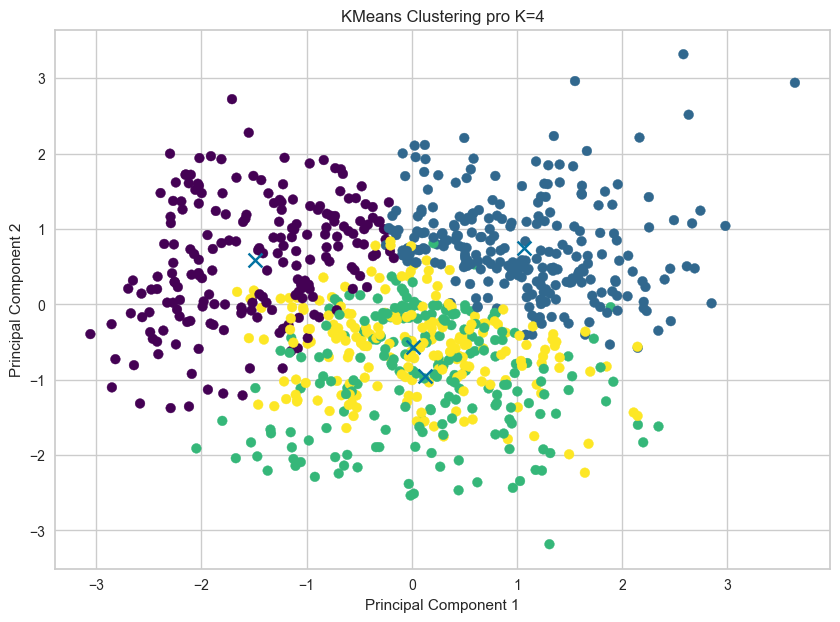

/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


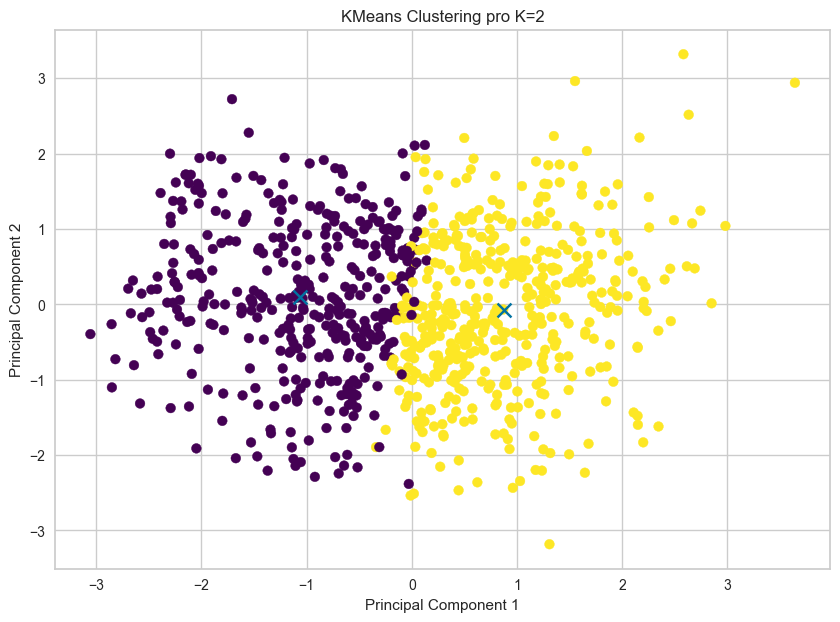

Text(0, 0.5, 'HbA1c_level')

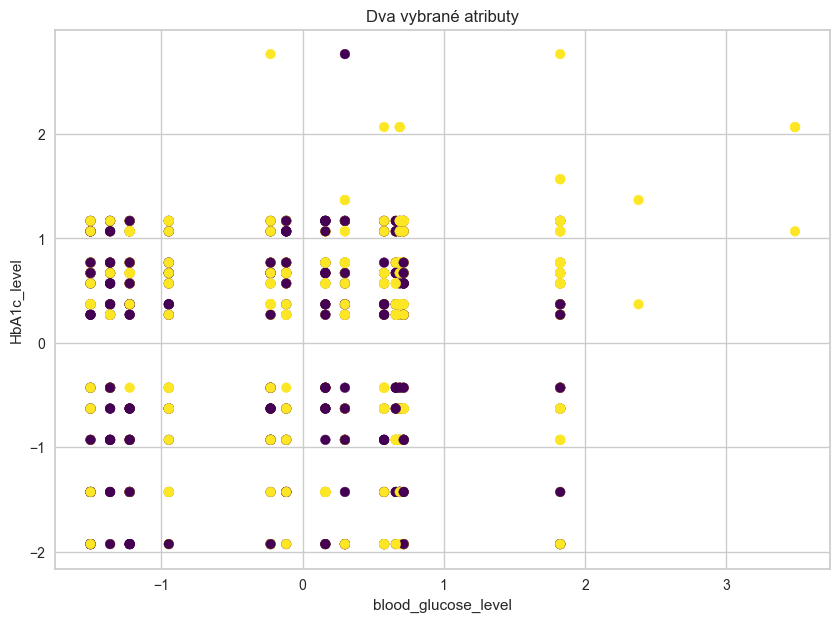

In [41]:
#PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

#Určení centoridů
centroids = pca.transform(kmeansElbow.cluster_centers_)

#Vytvoření DataFramu s principal componenty
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['Cluster'] = kmeansElbow.labels_

# Plotování clusteru pro K=4
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')

# Plotování centroidů pro K=5
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering pro K=4')
plt.show()

#Plotování clusterů pro K=2
centroids = pca.transform(kmeansTwo.cluster_centers_)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['Cluster'] = kmeansTwo.labels_
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering pro K=2')
plt.show()


#plot pro dva vybrané atributy

kmeansTwoAttributes = KMeans(n_clusters=2, random_state=42)
kmeansTwoAttributes.fit(X)

plt.figure(figsize=(10, 7))
plt.scatter(X['blood_glucose_level'], X['HbA1c_level'], c=kmeansTwoAttributes.labels_, cmap='viridis')

plt.title('Dva vybrané atributy')
plt.xlabel('blood_glucose_level')
plt.ylabel('HbA1c_level')

### Clustering  2 (hierarchical)

* Try to use the dendrogram to identify outliers. If an instance joins a cluster higher on the dendrogram, it generally means it is less similar to the other instances. 

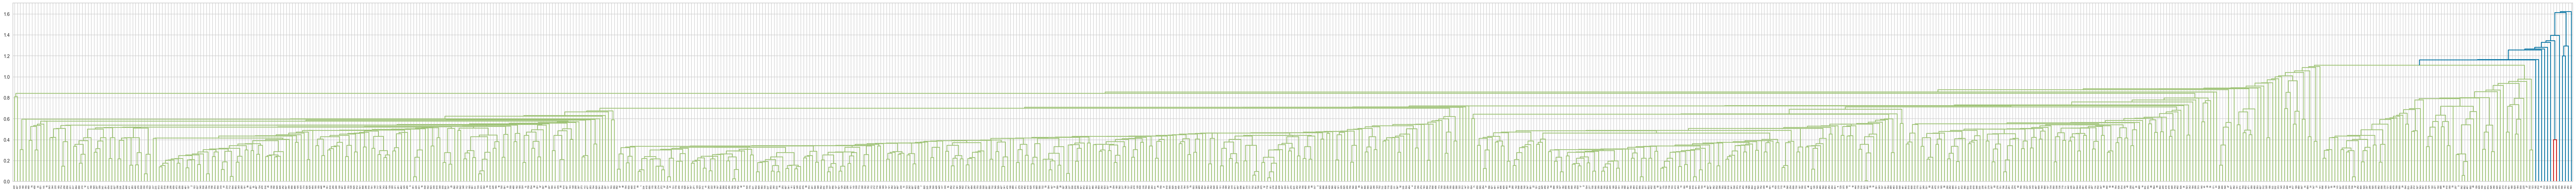

In [42]:
linked = linkage(X, 'single')

plt.figure(figsize=(100, 7 ))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# Evaluation

## Global

### Clustering 1 (k-means)

* Compute the rand index using the value of the target attribute

In [43]:
y = data.loc[X.index, 'diabetes']


ari = adjusted_rand_score(y, kmeansElbow.labels_)
ariTwo = adjusted_rand_score(y,kmeansTwo.labels_)

print("ARI pro k=4: ", ari)
print("ARI pro k=2: ", ariTwo)


ARI pro k=4:  -0.0033791043486413245
ARI pro k=2:  -0.006539700904146268


### Clustering 2 (hierarchical)


* Compute the rand index using the value of the target attribute

In [44]:

clusters = fcluster(linked, 4, criterion='maxclust')


y = data.loc[X.index, 'diabetes']

ari = adjusted_rand_score(y, clusters)

print("ARI: ", ari)

ARI:  0.29755651699350943


## Local

*	Use the model to classify the chosen instance into a cluster

age                    1.695016
hypertension           0.000000
heart_disease          0.000000
bmi                    0.049867
HbA1c_level           -0.430438
blood_glucose_level    0.161832
Name: 44914, dtype: float64
        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  1.695016           0.0            0.0  0.049867    -0.430438   

   blood_glucose_level  
0             0.161832  
Cluster label:  [1]


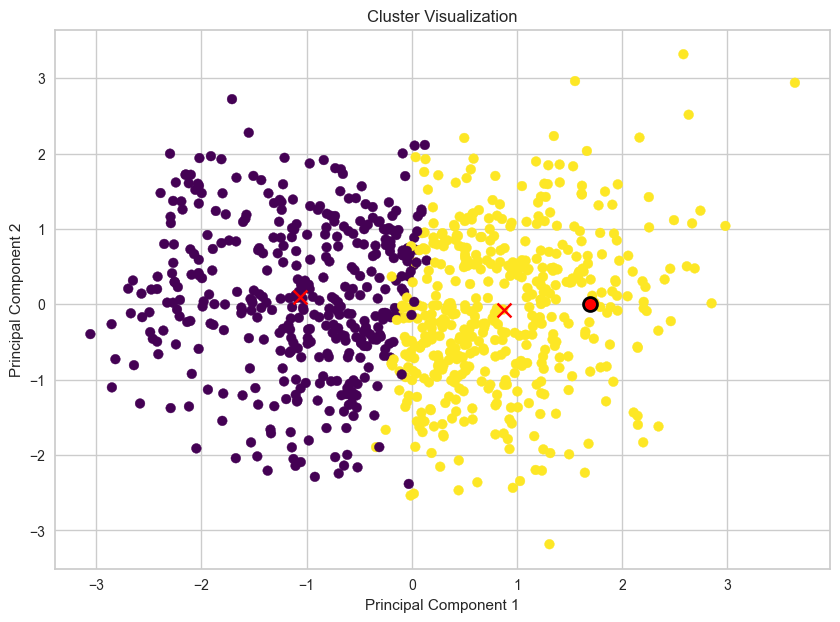

In [45]:
# Vybrání instance, která má podlé cílové proměnné cukrovku
instance_of_interest = X.iloc[414]

print(instance_of_interest)
#reshapování instance_of_interest
instance_of_interest = instance_of_interest.values.reshape(1, -1)
instance_of_interest = pd.DataFrame(instance_of_interest, columns=X.columns)
print(instance_of_interest)

cluster_label = kmeansElbow.predict(instance_of_interest)
print("Cluster label: ", cluster_label)

labels = kmeansElbow.labels_


# Plotování clusterů
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')

# Plotování centroidů
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c="red",s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.scatter(instance_of_interest.iloc[0, 0], instance_of_interest.iloc[0, 1], c='red', edgecolor='black', linewidth=2, s=100)
plt.show()


# Explanation

## Global explanation

### Clustering 1 - k-means

*	Interpret the final clusters based on their centroids and the number of instances in each cluster.

In [46]:

centroids = kmeansElbow.cluster_centers_


unique, counts = np.unique(kmeansElbow.labels_, return_counts=True)
cluster_counts = dict(zip(unique, counts))

print("Cluster Centroids:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}:")
    for j, column in enumerate(X.columns):
        print(f"{column}: {centroid[j]}")


print("\nNumber of Instances in Each Cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} instances")

Cluster Centroids:
Cluster 0:
age: -1.161332180487307
hypertension: 0.0
heart_disease: 0.0
bmi: -1.0878821187478809
HbA1c_level: 0.008034899061756858
blood_glucose_level: 0.21011550536164886
Cluster 1:
age: 0.6819415028020763
hypertension: 0.0
heart_disease: 0.0
bmi: 0.4666654694768202
HbA1c_level: 0.6945966645490608
blood_glucose_level: 0.7265312308072651
Cluster 2:
age: 0.20246675229491742
hypertension: 0.0
heart_disease: 0.0
bmi: 0.36163710672905697
HbA1c_level: -1.2855699374789453
blood_glucose_level: 0.04841990288336305
Cluster 3:
age: 0.09458926719874945
hypertension: 0.0
heart_disease: 0.0
bmi: 0.13160255364758708
HbA1c_level: 0.40737106426936587
blood_glucose_level: -1.158958322571274

Number of Instances in Each Cluster:
Cluster 0: 202 instances
Cluster 1: 255 instances
Cluster 2: 204 instances
Cluster 3: 205 instances


### Clustering 2 - hierarchical

* Plot the dendrogram for clustering

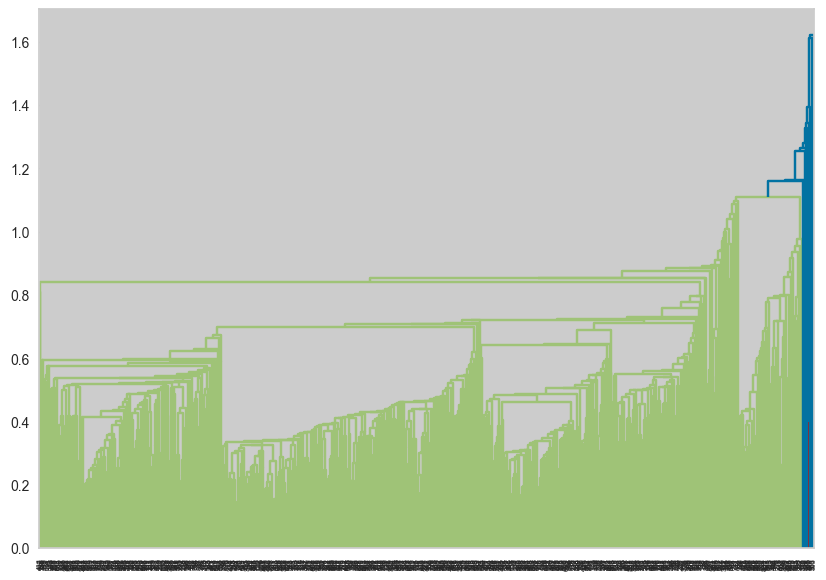

In [47]:
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

## Local explanation

* Use both models to show what cluster is assigned to the *instance of interest*
* Comment on the assigned cluster.

In [49]:
# K-means model
kmeans_cluster = kmeansElbow.predict(instance_of_interest)
print("K-means Cluster: ", kmeans_cluster)

# Hierarchical model
hierarchical_cluster = fcluster(linked, 4, criterion='maxclust')
hierarchical_cluster = hierarchical_cluster[414]  
print("Hierarchical Cluster: ", hierarchical_cluster)


K-means Cluster:  [1]
Hierarchical Cluster:  2


# Conclusion
Summarize the results, answering questions such as:

1.	Which clustering provided the most useful result? - 
    Kmeans s n_clusters = 4 (lepší ari a inertia)
2.	What setting provided the best result? - 
    K= 4 - zjištěno z elbow grafu

# Optional parts

## Local explanation

*	Does the value of the target class in the data match with the mode (average) of the assigned cluster? As the target attribute was not included in the clustering, to compute this, you need to  match the instance of interest as well as the instances in the assigned cluster with the original input data and use this to obtain the target value (and compute the mean/mode for the assigned cluster)